# Data Exploration of Trump Tweets

Barak Krakauer, July 2016

The current analysis is based on 3247 tweets pulled 7/14/2016, and n retweets selected from 10 random Trump tweets (see the scraper files for more information)


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import linear_model, neighbors, ensemble, cross_validation, grid_search, metrics

pd.set_option('display.max_rows', 10)
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_columns', 10)

%matplotlib inline
plt.style.use('ggplot')

In [2]:
df = pd.read_csv('trump_tweets.csv')
df.drop(["id"], axis=1, inplace=True)
df.head()

,text,created_at,favorite_count,retweet_count
0,I employ many people in the State of Virginia ...,2016-07-14 17:23:58,13466,4401
1,Another new poll. Thank you for your support! ...,2016-07-14 14:53:46,15456,6047
2,Great new poll- thank you America!\n#Trump2016...,2016-07-14 13:21:48,17037,5775
3,I will be making the announcement of my Vice P...,2016-07-14 01:19:51,40583,15757
4,"If I win the Presidency, we will swamp Justice...",2016-07-13 22:28:44,22560,7167


## What does the distribution of favorites look like?

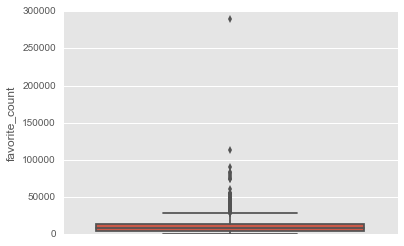

In [3]:
sns.boxplot(y="favorite_count", data=df)

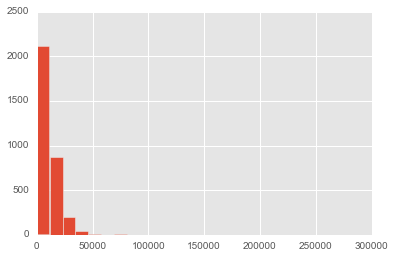

In [4]:
df["favorite_count"].hist(bins=25)

In [5]:
df.sort_values("favorite_count", ascending=False)

,text,created_at,favorite_count,retweet_count
324,How long did it take your staff of 823 people ...,2016-06-09 20:40:32,289164,170606
732,Happy #CincoDeMayo! The best taco bowls are ma...,2016-05-05 18:57:30,113368,83588
293,Is President Obama going to finally mention th...,2016-06-12 17:58:00,91042,39458
326,Obama just endorsed Crooked Hillary. He wants ...,2016-06-09 18:22:21,83089,36243
47,Prayers and condolences to all of the families...,2016-07-08 11:02:41,83007,28929
...,...,...,...,...
789,RT @AdrianaCohen16: Carly Fiorina no lifeboat ...,2016-04-29 00:32:22,0,2223
1631,RT @EricTrump: Very proud of what my father ha...,2016-02-24 01:52:12,0,2123
1628,RT @TrumpNV: #NVcaucus locator -&gt; https://t...,2016-02-24 01:59:59,0,809
805,RT @DonaldJTrumpJr: An Honor to be in #Indiana...,2016-04-27 22:06:11,0,4853


In [6]:
df[["favorite_count", "retweet_count"]].corr()

,favorite_count,retweet_count
favorite_count,1.000000,0.923622
retweet_count,0.923622,1.000000


Unsurprisingly, retweets and favorites are highly correlated.

(0, 100000)

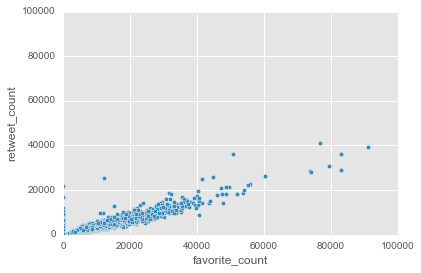

In [7]:
a = df.plot(kind='scatter', x='favorite_count', y='retweet_count')
a.set_ylim(0,100000)
a.set_xlim(0,100000)

## Retweets and sentiment

In [8]:
from nltk import tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

df["sentiment"] = 0
df.sentiment = df.text.apply(lambda line: sid.polarity_scores(line))
df.head()

,text,created_at,favorite_count,retweet_count,sentiment
0,I employ many people in the State of Virginia ...,2016-07-14 17:23:58,13466,4401,"{u'neg': 0.0, u'neu': 0.892, u'pos': 0.108, u'..."
1,Another new poll. Thank you for your support! ...,2016-07-14 14:53:46,15456,6047,"{u'neg': 0.0, u'neu': 0.6, u'pos': 0.4, u'comp..."
2,Great new poll- thank you America!\n#Trump2016...,2016-07-14 13:21:48,17037,5775,"{u'neg': 0.0, u'neu': 0.504, u'pos': 0.496, u'..."
3,I will be making the announcement of my Vice P...,2016-07-14 01:19:51,40583,15757,"{u'neg': 0.0, u'neu': 1.0, u'pos': 0.0, u'comp..."
4,"If I win the Presidency, we will swamp Justice...",2016-07-13 22:28:44,22560,7167,"{u'neg': 0.0, u'neu': 0.591, u'pos': 0.409, u'..."


In [9]:
df["comp"] = df.sentiment.apply(lambda sent: sent["compound"])
df.head()

,text,created_at,favorite_count,retweet_count,sentiment,comp
0,I employ many people in the State of Virginia ...,2016-07-14 17:23:58,13466,4401,"{u'neg': 0.0, u'neu': 0.892, u'pos': 0.108, u'...",0.4199
1,Another new poll. Thank you for your support! ...,2016-07-14 14:53:46,15456,6047,"{u'neg': 0.0, u'neu': 0.6, u'pos': 0.4, u'comp...",0.7896
2,Great new poll- thank you America!\n#Trump2016...,2016-07-14 13:21:48,17037,5775,"{u'neg': 0.0, u'neu': 0.504, u'pos': 0.496, u'...",0.7840
3,I will be making the announcement of my Vice P...,2016-07-14 01:19:51,40583,15757,"{u'neg': 0.0, u'neu': 1.0, u'pos': 0.0, u'comp...",0.0000
4,"If I win the Presidency, we will swamp Justice...",2016-07-13 22:28:44,22560,7167,"{u'neg': 0.0, u'neu': 0.591, u'pos': 0.409, u'...",0.8398


In [10]:
df[df.comp == min(df.comp)]

,text,created_at,favorite_count,retweet_count,sentiment,comp
114,Yet another terrorist attack today in Israel -...,2016-07-01 15:51:46,9601,4244,"{u'neg': 0.548, u'neu': 0.452, u'pos': 0.0, u'...",-0.9584


In [11]:
df[df.comp == max(df.comp)]

,text,created_at,favorite_count,retweet_count,sentiment,comp
2485,I would like to wish everyone A HAPPY AND HEAL...,2015-12-31 23:21:49,16718,6922,"{u'neg': 0.0, u'neu': 0.452, u'pos': 0.548, u'...",0.9713


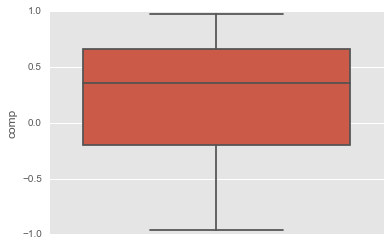

In [12]:
sns.boxplot(y="comp", data=df)

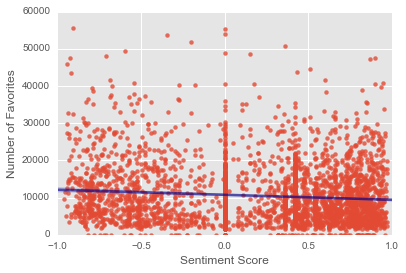

In [13]:
a = sns.regplot(x="comp", y="favorite_count", data=df[df.favorite_count < 60000], line_kws={"color": "darkblue", "alpha":.6}) 
# removed outliers above.
a.set_ylim(0,)
a.set_xlim(-1,1)
a.set_xlabel("Sentiment Score")
a.set_ylabel("Number of Favorites")

In [14]:
# Note that we've removed a couple of outliers and forced the intercept to 0 for this model.

model = smf.ols(formula="favorite_count ~ comp + 0", data=df[df.favorite_count < 100000]).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         favorite_count   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                     124.7
Date:                Tue, 19 Jul 2016   Prob (F-statistic):           1.97e-28
Time:                        14:01:27   Log-Likelihood:                -35485.
No. Observations:                3245   AIC:                         7.097e+04
Df Residuals:                    3244   BIC:                         7.098e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
comp        4625.0494    414.225     11.166      0.000      3812.881  5437.218
==============================================================================
Omnibus:                     1590.614   Durbin-Watson:                   0.409
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            14293.547
Skew:                           2.135   Prob(JB):                         0.00
Kurtosis:                      12.353   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The relation between the sentiment of a tweet and the number of favorites it gets is highly significant; a model that considers the sentiment of a tweet alone would not do a great job of predicting retweets (r^2 = .037). Generally speaking, however, we can say that moving from a neutral tweet to a highly negative tweet would earn Trump an addition 4600 retweets.

## What words are used in the most re-tweeted tweets?

In [15]:
from nltk.tokenize import TweetTokenizer

twtk = TweetTokenizer()
twtk.tokenize("st")
df["tokenized"] = df.text.apply(lambda x: twtk.tokenize(x.lower()))
df

,text,created_at,favorite_count,retweet_count,sentiment,comp,tokenized
0,I employ many people in the State of Virginia ...,2016-07-14 17:23:58,13466,4401,"{u'neg': 0.0, u'neu': 0.892, u'pos': 0.108, u'...",0.4199,"[i, employ, many, people, in, the, state, of, ..."
1,Another new poll. Thank you for your support! ...,2016-07-14 14:53:46,15456,6047,"{u'neg': 0.0, u'neu': 0.6, u'pos': 0.4, u'comp...",0.7896,"[another, new, poll, ., thank, you, for, your,..."
2,Great new poll- thank you America!\n#Trump2016...,2016-07-14 13:21:48,17037,5775,"{u'neg': 0.0, u'neu': 0.504, u'pos': 0.496, u'...",0.7840,"[great, new, poll, -, thank, you, america, !, ..."
3,I will be making the announcement of my Vice P...,2016-07-14 01:19:51,40583,15757,"{u'neg': 0.0, u'neu': 1.0, u'pos': 0.0, u'comp...",0.0000,"[i, will, be, making, the, announcement, of, m..."
4,"If I win the Presidency, we will swamp Justice...",2016-07-13 22:28:44,22560,7167,"{u'neg': 0.0, u'neu': 0.591, u'pos': 0.409, u'...",0.8398,"[if, i, win, the, presidency, ,, we, will, swa..."
...,...,...,...,...,...,...,...
3242,"""@jrpantiques: @realDonaldTrump @TheFix @pbump...",2015-11-22 22:33:42,2404,1009,"{u'neg': 0.0, u'neu': 0.813, u'pos': 0.187, u'...",0.7034,"["", @jrpantiques, :, @realdonaldtrump, @thefix..."
3243,"""@bloggerjulie: @FoxNews The reporter is the o...",2015-11-22 22:32:42,2356,1130,"{u'neg': 0.146, u'neu': 0.854, u'pos': 0.0, u'...",-0.5014,"["", @bloggerjulie, :, @foxnews, the, reporter,..."
3244,"""@MJP1370: @realDonaldTrump @TheFix @pbump We ...",2015-11-22 22:32:09,2568,1152,"{u'neg': 0.0, u'neu': 1.0, u'pos': 0.0, u'comp...",0.0000,"["", @mjp1370, :, @realdonaldtrump, @thefix, @p..."
3245,"""@TheFix: The Paris attacks have only made Don...",2015-11-22 22:26:06,2898,1513,"{u'neg': 0.147, u'neu': 0.556, u'pos': 0.297, ...",0.4561,"["", @thefix, :, the, paris, attacks, have, onl..."


In [16]:
def word_freqs(words):
    freqs = {}
    for tweet in words:
        for word in tweet:
            if word in freqs:
                freqs[word] += 1
            else:
                freqs[word] = 1
    return freqs

freqs = word_freqs(df.tokenized.tolist())

In [17]:
import re

# for every word, find the avg of retweets in the tweets in which it occurs!

for key, val in freqs.iteritems():
    clean_term = re.escape(key)
    avg = np.mean(df[df.text.str.lower().str.contains(clean_term)].retweet_count)
    freqs[key] = [val, avg]

# How often does "Hillary" appear in tweets and how many retweets, on average, do these tweets get?    
freqs["hillary"]

[292, 6938.862416107382]

In [18]:
# Make this into a df...

freqdf = pd.DataFrame(freqs).transpose()
freqdf.columns = ["count", "avg_rts"]
freqdf

,count,avg_rts
!,2509.0,4073.473920
"""",1678.0,2308.649485
#,17.0,3651.290393
#2016,1.0,1031.000000
#2a,3.0,8022.666667
...,...,...
�,1.0,NaN
�,1.0,NaN
�,3.0,NaN
�,1.0,NaN


In [19]:
# Which words appear in the most retweeted tweets?

pd.set_option('display.max_rows', 100)

# (Make sure the word is used at least five times, to eliminate outliers)

freqdf[freqdf["count"] > 4].sort_values("avg_rts", ascending=False)

,count,avg_rts
email,6.0,26325.555556
families,5.0,16152.400000
charges,7.0,14554.571429
prayers,5.0,14505.600000
victims,5.0,13363.400000
chicago,5.0,13329.200000
fbi,6.0,12700.833333
33,7.0,12675.388889
endorsing,6.0,12251.600000
vigilant,9.0,11851.222222


The words most associated with high numbers of retweets are "emails," "families," "charges," "prayers," and "victims." These words appear in tweets that are retweeted, on average, more than three times as much the average tweet.

## Where are these retweets coming from?

In [20]:
pd.set_option('display.max_rows', 10)

rtdf = pd.read_csv('trumpsretweets.csv')
rtdf.head(10)

,text,user_location
0,RT @realDonaldTrump: Look forward to Governor ...,Reward if u find me! lol USA
1,RT @realDonaldTrump: Look forward to Governor ...,NaN
2,RT @realDonaldTrump: Look forward to Governor ...,NaN
3,RT @realDonaldTrump: Look forward to Governor ...,"Tampa, FL"
4,RT @realDonaldTrump: Look forward to Governor ...,NaN
5,RT @realDonaldTrump: Look forward to Governor ...,NaN
6,RT @realDonaldTrump: Look forward to Governor ...,"Windsor, VA"
7,RT @realDonaldTrump: Look forward to Governor ...,"Long Island,NY"
8,RT @realDonaldTrump: Look forward to Governor ...,"Ohio, USA"
9,RT @realDonaldTrump: Look forward to Governor ...,NaN


In [21]:
rtdf.user_location.value_counts()

United States            878
USA                      432
Texas, USA               236
California, USA          232
Florida, USA             218
                        ... 
Swindon, England           1
wherever I Want To Be      1
Wichita, Kansas USA        1
I'm from Earth             1
Judevine Mountain          1
Name: user_location, dtype: int64

In [22]:
def get_state(loc):
    loc = str(loc).lower()
    state = np.nan
    
    if 'alabama' in loc or ', al' in loc:
        state = "AL"
    elif 'alaska' in loc or ', ak' in loc:
        state = "AK"
    elif 'arizona' in loc or ', az' in loc:
        state = "AZ"
    elif 'california' in loc or ', ca' in loc:
        state = "CA"
    elif 'colorado' in loc or ', co' in loc:
        state = "CO"
    elif 'connecticut' in loc or ', ct' in loc:
        state = "CT"
    elif 'delaware' in loc or ', de' in loc:
        state = "DE"
    elif 'florida' in loc or ', fl' in loc:
        state = "FL"
    elif 'georgia' in loc or ', ga' in loc:
        state = "GA"
    elif 'hawaii' in loc or ', hi' in loc:
        state = "HI"
    elif 'idaho' in loc or ', id' in loc:
        state = "ID"
    elif 'illinois' in loc or ', il' in loc:
        state = "IL"
    elif 'indiana' in loc or ', in' in loc:
        state = "IN"
    elif 'iowa' in loc or ', ia' in loc:
        state = "IA"
    elif 'kansas' in loc or ', ks' in loc:
        state = "KS"
    # We have to evaluate arkansas after kansas because the former is a substring of the later
    if 'arkansas' in loc or ', ar' in loc:
        state = "AR"
    elif 'kentucky' in loc or ', ky' in loc:
        state = "KY"
    elif 'louisana' in loc or ', la' in loc:
        state = "LA"
    elif 'maine' in loc or ', me' in loc:
        state = "ME"
    elif 'maryland' in loc or ', md' in loc:
        state = "MD"
    elif 'massachusetts' in loc or ', ma' in loc:
        state = "MA"
    elif 'michigan' in loc or ', mi' in loc:
        state = "MI"
    elif 'minnesota' in loc or ', mn' in loc:
        state = "MN"
    elif 'mississippi' in loc or ', mi' in loc:
        state = "MS"
    elif 'missouri' in loc or ', mo' in loc:
        state = "MO"
    elif 'montana' in loc or ', mt' in loc:
        state = "MT"
    elif 'nebraska' in loc or ', ne' in loc:
        state = "NE"
    elif 'nevada' in loc or ', nv' in loc:
        state = "NV"
    elif 'new hampshire' in loc or ', ak' in loc:
        state = "NH"
    elif 'new jersey' in loc or ', ak' in loc:
        state = "NJ"
    elif 'new mexico' in loc or ', nm' in loc:
        state = "NM"
    # We can handle 'nyc' as a special case because there may be enough of them to warrant it...
    elif 'new york' in loc or ', ny' in loc:
        state = "NY"
    elif 'north carolina' in loc or ', nc' in loc:
        state = "NC"
    elif 'north dakota' in loc or ', nd' in loc:
        state = "ND"
    elif 'ohio' in loc or ', oh' in loc:
        state = "OH"
    elif 'oklahoma' in loc or ', ok' in loc:
        state = "OK"
    elif 'oregon' in loc or ', or' in loc:
        state = "OR"
    elif 'pennsylvania' in loc or ', pa' in loc:
        state = "PA"
    elif 'rhode island' in loc or ', ri' in loc:
        state = "RI"
    elif 'south carolina' in loc or ', sc' in loc:
        state = "SC"
    elif 'south dakota' in loc or ', sd' in loc:
        state = "SD"
    elif 'tennessee' in loc or ', tn' in loc:
        state = "TN"
    elif 'texas' in loc or ', tx' in loc:
        state = "TX"
    elif 'utah' in loc or ', ut' in loc:
        state = "UT"
    elif 'vermont' in loc or ', vt' in loc:
        state = "VT"
    elif 'virginia' in loc or ', va' in loc:
        state = "VA"
    elif 'washington' in loc or ', wa' in loc:
        state = "WA"
    # This is an 'if' to catch virginia -> west virginia if necessary.
    if 'west virginia' in loc or ', wv' in loc:
        state = "WV"
    elif 'wisconsin' in loc or ', wi' in loc:
        state = "WI"
    elif 'wyoming' in loc or ', wy' in loc:
        state = "WY"
    elif 'district of columbia' in loc or ', dc' in loc:
        state = "DC"
    
    return state
        
rtdf["state"] = rtdf.user_location.apply(get_state)
rtdf

,text,user_location,state
0,RT @realDonaldTrump: Look forward to Governor ...,Reward if u find me! lol USA,NaN
1,RT @realDonaldTrump: Look forward to Governor ...,NaN,NaN
2,RT @realDonaldTrump: Look forward to Governor ...,NaN,NaN
3,RT @realDonaldTrump: Look forward to Governor ...,"Tampa, FL",FL
4,RT @realDonaldTrump: Look forward to Governor ...,NaN,NaN
...,...,...,...
29595,"RT @realDonaldTrump: In the last 2 weeks, I ha...",NaN,NaN
29596,"RT @realDonaldTrump: In the last 2 weeks, I ha...",NaN,NaN
29597,"RT @realDonaldTrump: In the last 2 weeks, I ha...","Charlotte, NC",NC
29598,"RT @realDonaldTrump: In the last 2 weeks, I ha...",NaN,NaN


In [23]:
rtdf.state.value_counts()

CA    1089
FL     974
TX     970
NY     685
OH     357
      ... 
AK      19
SD       9
WY       8
ND       6
VT       6
Name: state, dtype: int64

In [24]:
rtdf.dropna(inplace=True)
len(rtdf)

9255

In [25]:
rtdf.groupby('state').size()

state
AK      19
AL     202
AR      86
AZ     212
CA    1089
      ... 
VT       6
WA     175
WI      88
WV      43
WY       8
dtype: int64

In [26]:
# making a dataframe of just the states and retweet counts

rtd = pd.DataFrame(rtdf.state.unique(), columns=['state'])
rtd["counts"] = rtd.state.apply(lambda x: len(rtdf[rtdf.state == x]))
rtd

,state,counts
0,FL,974
1,VA,206
2,OH,357
3,WA,175
4,MI,245
...,...,...
46,AK,19
47,ME,45
48,SD,9
49,VT,6


In [27]:
# add population for each state (in millions)
pops = {
    "AL": 4.9,
    "AK": .7,
    "AZ": 6.8,
    "AR": 3,
    "CA": 39.1,
    "CO": 5.5,
    "CT": 3.6,
    "DE": .9,
    "FL": 20,
    "GA": 10.2,
    "HI": 1.4,
    "ID": 1.7,
    "IL": 12.9,
    "IN": 6.6,
    "IA": 3.1,
    "KS": 2.9,
    "KY": 4.4,
    "LA": 4.7,
    "ME": 1.3,
    "MD": 6,
    "MA": 6.8,
    "MI": 10,
    "MN": 5.5,
    "MS": 3,
    "MO": 6.1,
    "MT": 1,
    "NE": 1.9,
    "NV": 2.9,
    "NH": 1.3,
    "NJ": 9,
    "NM": 2.1,
    "NY": 20,
    "NC": 10,
    "ND": .8,
    "OH": 11.6,
    "OK": 3.9,
    "OR": 4,
    "PA": 12.8,
    "RI": 1,
    "SC": 4.9,
    "SD": .9,
    "TN": 6.6,
    "TX": 27.5,
    "UT": 3,
    "VT": .6,
    "VA": 8.4,
    "WA": 7.2,
    "WV": 1.8,
    "WI": 5.8,
    "WY": .6,
    "DC": .7
}

rtd['population'] = rtd.state.apply(lambda x: pops[x])
rtd['scaled_counts'] = rtd.counts / rtd.population

In [28]:
#create maps of retweets

import folium
import json

#thresh = [0,400]
state_geo = 'us-states.json'
tmap = folium.Map(location=[34.5,-102], zoom_start=4)
tmap.geo_json(geo_path=state_geo, data=rtd, columns=['state', 'counts'], fill_color='YlGn', key_on='feature.id', \
              fill_opacity = .7, line_opacity=.2, legend_name='Retweet Count by State')
tmap

C:\Users\bkrak_000\Anaconda2\lib\site-packages\folium\folium.py:504: UserWarning: This method is deprecated. Please use Map.choropleth instead.
  warnings.warn('This method is deprecated. '
C:\Users\bkrak_000\Anaconda2\lib\site-packages\folium\folium.py:506: FutureWarning: 'threshold_scale' default behavior has changed. Now you get a linear scale between the 'min' and the 'max' of your data. To get former behavior, use folium.utilities.split_six.
  return self.choropleth(*args, **kwargs)


It's not surprising that most retweets come from high-population states like California, New York, and Texas! We need to scale this by population, which I do below...

In [29]:
#create map of scaled retweets

tmap = folium.Map(location=[34.5,-102], zoom_start=4)
tmap.geo_json(geo_path=state_geo, data=rtd, columns=['state', 'scaled_counts'], fill_color='PuBu', key_on='feature.id', \
              fill_opacity = .7, line_opacity=.2, legend_name='Retweet Count by State')
tmap

In this map, states like California and New York fade closer to average (though still somewhat high; perhaps this is due to increased penetration of Twitter?). Worryingly for Clinton, some battleground states such as Nevada and Florida are quite high!


In [30]:
rtd.sort_values(["scaled_counts"], ascending=False)

,state,counts,population,scaled_counts
29,DC,66,0.7,94.285714
18,NE,141,1.9,74.210526
24,NV,151,2.9,52.068966
0,FL,974,20.0,48.700000
20,AL,202,4.9,41.224490
...,...,...,...,...
35,UT,35,3.0,11.666667
41,MS,32,3.0,10.666667
48,SD,9,0.9,10.000000
49,VT,6,0.6,10.000000


It's notable here that DC tops the list! This is likely just do to increased presence of media and politics, rather than actual support for Trump. Many of the states toward the bottom of the list are states where Trump will probably do well, such as the Dakota and Mississippi -- this is probably due to Twitter penetration. Perhaps a third map that controls for this can confirm this hypothesis.